In [1]:
import torch
import sys
import numpy as np
import pylab as plt
import openslide as ops

sys.path.append('../')
from Model.PatchCNN import PatchCNN
from Data.CRLM import CRLM

In [2]:
device = torch.device("cuda:0")
num_layers = [3,4,6,3]  # res34
#num_layers = [2,2,2,2] # res18
dropout_rate = 0
#dilation = 2
model = PatchCNN(layers=num_layers,dropout_rate=dropout_rate)
state_dict = torch.load('/mnt/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_448_res34/PatchCNN_best.pth')
#state_dict = torch.load('/mnt/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_448_res18/PatchCNN_best.pth')
new_state_dict = {}
for key in model.state_dict():
    new_state_dict[key] = state_dict['module.'+key].double()
model.load_state_dict(new_state_dict)
model.eval()
model.to(device)

PatchCNN(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [3]:
def process_large_image(model,input_patch,step = 28,out_scale =4,num_classes= 11,patch_size = 448,show=False):
    """
    step = 28   #sliding window step size
    out_scale =4   # the output shape of the network
    num_classes= 11   # the number of classes 
    patch_size = 448     # the patch size of the 
    """
    if input_patch.max()>2:
        test_img = input_patch/255.0
    else:
        test_img = input_patch
    tt = torch.from_numpy(((test_img[:,:,(2,1,0)]-np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.224, 0.225])).transpose(2,0,1)).float()

    ta =tt.unfold(2,patch_size,step)
    #print(ta.size())
    tb = ta.unfold(1,patch_size,step)
    #print(tb.size())
    tc = tb.permute((1,2,0,3,4))
    #print(tc.shape)
    td = tc.reshape(-1,3,patch_size,patch_size)
    #print(td.shape)
    nx = len(range(0,test_img.shape[0]-patch_size+1,step))
    ny = len(range(0,test_img.shape[1]-patch_size+1,step))

    final_tensor = td
    final_result2 = []
    for i in range(nx):
        test_tensor = final_tensor[i*ny:i*ny+ny]
        out = model(test_tensor.cuda())
        softmax = torch.nn.Softmax2d()
        out2 = softmax(out)
        final_result2.append(out2.detach().cpu().numpy())
        torch.cuda.empty_cache()

    t = np.array(final_result2).transpose(0,3,1,4,2).reshape(nx*out_scale,ny*out_scale,num_classes)
    if show:
        plt.subplot(1,2,1)
        plt.imshow(test_img)
        plt.subplot(1,2,2)
        plt.imshow(np.argmax(t[:,:,:],2))
    return t

#result = process_large_image(model,test_img[:1024,:1024,:3],show=True)

In [10]:
def process_wsi_old(model,slide_path,small_step = 56,small_patch_size=448,out_scale =4,num_classes =11):
    sl = ops.OpenSlide(slide_path)
    
    #small_step = 224    # should be times of 28
    large_patch_size =  small_patch_size*(small_step//56)*4
    large_step= large_patch_size-small_patch_size+small_patch_size
    patch_result_size = (large_patch_size-small_patch_size)//small_step+1

    

    lnx = len(range(0,sl.dimensions[0]-large_patch_size+1,large_step))
    lny = len(range(0,sl.dimensions[1]-large_patch_size+1,large_step))
    result_array = np.zeros(( lnx*patch_result_size*out_scale,lny*patch_result_size*out_scale,num_classes))

    for i in range(lnx):
        for j in range(lny):
            tpatch = np.array(sl.read_region((i*large_patch_size,j*large_patch_size),\
                                             0,(large_patch_size,large_patch_size)))
            tpatch_result = process_large_image(model,input_patch=tpatch,out_scale=out_scale,step=small_step,num_classes=num_classes,patch_size=small_patch_size)
            result_array[j*patch_result_size*out_scale:(j+1)*patch_result_size*out_scale,\
                        i*patch_result_size*out_scale:(i+1)*patch_result_size*out_scale,:] = tpatch_result.transpose(1,0,2)
    
    return result_array

In [7]:

def process_wsi(model,slide_path,small_step = 56,small_patch_size=448,out_scale =4,num_classes =11):
    sl = ops.OpenSlide(slide_path)
    
    #small_step = 224    # should be times of 28
    large_patch_size =  small_patch_size*(small_step//56)*4
    large_step= large_patch_size-small_patch_size+small_patch_size
    patch_result_size = (large_patch_size-small_patch_size)//small_step+1


    lnx = len(range(0,sl.dimensions[1]-large_patch_size+1,large_step))
    lny = len(range(0,sl.dimensions[0]-large_patch_size+1,large_step))
    
    result_array = np.zeros((lnx*patch_result_size*out_scale,lny*patch_result_size*out_scale,num_classes))

    for j in range(lnx):
        for i in range(lny):
            try:
                tpatch = np.array(sl.read_region(\
                                                 (i*large_patch_size,j*large_patch_size),\
                                                 0,(large_patch_size,large_patch_size)))
                tpatch_result = process_large_image(model,input_patch=tpatch,out_scale=out_scale,step=small_step,\
                                                    num_classes=num_classes,patch_size=small_patch_size)
                result_array[i*patch_result_size*out_scale:(i+1)*patch_result_size*out_scale,\
                             j*patch_result_size*out_scale:(j+1)*patch_result_size*out_scale,:] = tpatch_result.transpose(1,0,2)
            except Exception as e:
                print(e)
    return result_array


In [ ]:
import numpy as np
import pylab as plt
import openslide as ops
import os
slide_path = os.path.expanduser('~')+'/DATA_CRLM/CRLM/Original/CRLM_041.ndpi'
result_array = process_wsi(model,slide_path,small_step=448)

In [1]:
import numpy as np
import pylab as plt
import os
import openslide as ops
slide_path = os.path.expanduser('~')+'/DATA_CRLM/CRLM/Original/CRLM_042.ndpi'
#result_array = np.load('/home/zyx31/DATA_CRLM/CRLM/Results/CRLM_041_pcnn_res448_step56.npy')
#result_array = np.load('/home/zyx31/DATA_CRLM/CRLM/Results/CRLM_041_pcnn_res448_small.npy')
result_array = np.load('/home/zyx31/DATA_CRLM/CRLM/Results/CRLM_042_pcnn_res448_step112.npy')


(-0.5, 4095.5, 2595.5, -0.5)

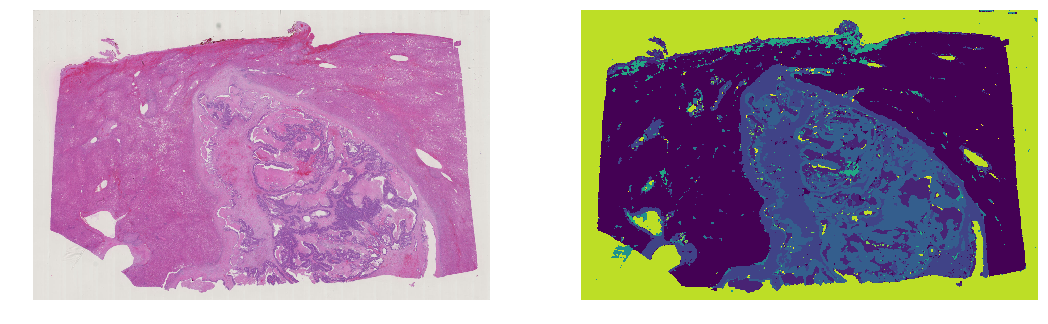

In [20]:
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
sl = ops.OpenSlide(slide_path)
level = 7
ttimage= sl.read_region((0,0),level,(sl.dimensions[0]//2**level,sl.dimensions[1]//2**level))
plt.imshow(ttimage)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.argmax(result_array[:,:,:],2).T)
plt.axis('off')

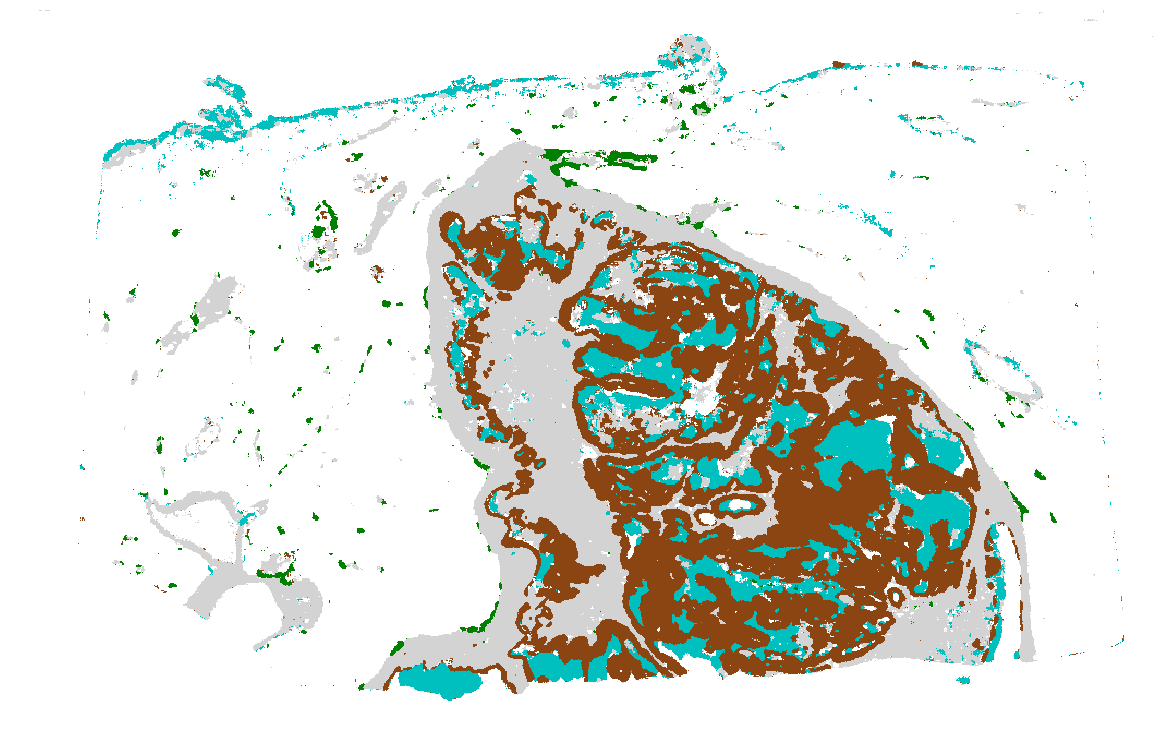

In [26]:
from matplotlib.colors import ListedColormap

cMap = ListedColormap(['pink','c','lightgrey','saddlebrown','g','r','purple','royalblue','k','white','gold'])
#cMap = ListedColormap(['white','hotpink','pink'])
plt.figure(figsize=(20,20))
tresult = np.argmax(result_array[:,:,:],2).T
plt.axis('off')
#plt.imshow(np.array(tresult!=9,dtype=np.int)+np.array(tresult==0,dtype=np.int),cmap=cMap)
#plt.imshow(np.array(tresult!=9,dtype=np.int),cmap=cMap)
#plt.imshow(tresult,cmap=cMap)
plt.imshow(np.array(tresult==1,dtype=np.int)+np.array(tresult==2,dtype=np.int)*2\
           +np.array(tresult==3,dtype=np.int)*3+np.array(tresult==4,dtype=np.int)*4,\
           cmap=ListedColormap(['white','c','lightgrey','saddlebrown','g']))

plt.savefig('/home/zyx31/Desktop/wsi_042.png',dpi=300)